#  Selecting genes for CRISPRi single knockdown libraries


## Goal:  To select a set of single gene knockdown to test high density. With 68 sgRNA's per gene we can select ~88 genes for analysis on a hiSeq lane with ~350 million reads.

### Filtering levels
1.  Gene must have YFP fusion for quantitation.
2.  Gene must have estimate copies per cell to test how copy number might influence titration amount. (Aebersold database has almost every single gene, so not much bottleneck at this step).
3.  Gene must be found in NC_000913.csv, which contains ontology, location on chromosome, etc.
4.  Gene must be found in Keio_Essential_edit.csv.  This sheet includes genes that could not be knocked out, so we can have an idea what a complete knockdown should look like.

Additionally, glycolysis and folate metabolism genes that do not meet these criteria were included.

## IMPORTANT:  There is random gene selection in this notebook, so the same set of genes won't be selected everytime.  Please see files in inputs folder for genes selected in CRISPRi titration experiment.

Written by Andrew Mathis

Updated 8 July 2020

## Import useful libraries

In [1]:
import random # Random sampling
import pandas as pd # Data organization
import numpy as np # Data organization
import matplotlib.pyplot as plt # Plotting function
# Renders figures in notebook
%matplotlib inline

## Establish paths and variables unique to this analysis

In [2]:
yfp_path = '../inputs/gene_selection_yfp_fusion.csv' # Path to YFP fusion data
concentration_path = '../inputs/gene_selection_Aebersold_p_conc.csv' # Path to protein concentration data
location_path = '../inputs/gene_selection_chromosomal_location.csv' # Path to chromosomal location data
essentiality_path = '../inputs/gene_selection_Keio_essential.csv' # Path to essentiality in MOPS data
figure_path = '../Figures/' # General path for saving figures

date = '20200707' # Date for output files

## Import data

In [3]:
# Import YFP fusion data
df_yfp = pd.read_csv(yfp_path, index_col=0, parse_dates=True)
df_yfp.columns = ['Gene', 'Name', 'Class', 'YFP', 'FISH']
df_yfp = df_yfp.loc[df_yfp['YFP'] == 1]
df_yfp.index = df_yfp['Gene']

# Import concentration data
df_conc = pd.read_csv(concentration_path, index_col=0, parse_dates=True)
df_conc2 = pd.DataFrame()
df_conc2['Gene'] = df_conc['Gene']
df_conc2['Copy_number'] = df_conc['glucose']
df_conc2 = df_conc2.T
df_conc2.columns = df_conc2.loc['Gene']
df_conc2 = df_conc2.T
df_conc2 = df_conc2.replace('below LOQ', -1)
df_conc2['Copy_number'] = np.array(df_conc2['Copy_number'], dtype='float')

# Import identification database
df_database = pd.read_csv(location_path, index_col=0, parse_dates=True)
df_database['Location'] = df_database.index
df_database.set_index('Gene', inplace=True)

# Import essentiality data
df_keio = pd.read_csv(essentiality_path, index_col=0, parse_dates=True)
df_keio.set_index('Gene', inplace=True)
df_keio = df_keio.replace('N.A.', 0) # Replace N.A. MOPS growth with 0 growth.
df_keio['MOPS_24hr'] = np.array(df_keio['MOPS_24hr'], dtype='float')

# COGs pathway key
L2Func = {'E':'Amino Acids Metabolism/Transport', 'D':'Cell Cycle Control/Mitosis', 
          'F':'Nucleotide Metabolism/Transport', 'I':'Lipid Metabolism', 'J':'Translation', 
          'M':'Cell wall/membrane/envelope Biogenesis', 'L':'Replication and Repair', 'H':'Coenzyme Metabolism', 
          'G':'Carbohydrate Metabolism/Transport'}

In [4]:
# Merge YFP and copy number data
df1 = pd.merge(df_yfp['YFP'], df_conc2['Copy_number'], left_index=True, right_index=True)
# Merge df1 with essentiality data in MOPS from Keio
df2 = pd.merge(df1, df_keio['MOPS_24hr'], left_index=True, right_index=True)
# Merge ID database
df3 = pd.merge(df2, df_database, left_index=True, right_index=True)
df3 = df3.replace('N.A.', 0) # Replace N.A. MOPS growth rate with 0 growth

df_KC = pd.merge(df_keio['MOPS_24hr'], df_database, left_index=True, right_index=True, how='outer')
df_KCY = pd.merge(df_KC, df_yfp, left_index=True, right_index=True, how='outer')
df_KCYA = pd.merge(df_KCY, df_conc2['Copy_number'], left_index=True, right_index=True, how='outer')

del df_KCYA['Product']
del df_KCYA['Gene']
del df_KCYA['Class']

## All proteins with Keio YFP fusions

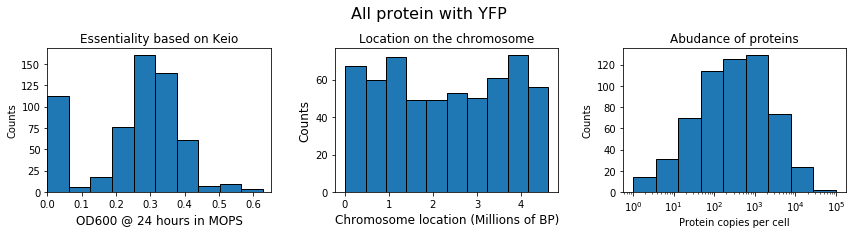

In [5]:
Chrom_loc = []
for loc in df3['Location']:
    Chrom_loc.append(int(loc.split('..')[0]))

plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.hist(df3['MOPS_24hr'], edgecolor='k')
plt.xlabel('OD600 @ 24 hours in MOPS', fontsize=12)
plt.ylabel('Counts')
plt.title('Essentiality based on Keio')
plt.xlim(0, 0.65)

plt.subplot(132)
plt.hist(Chrom_loc, edgecolor='k')
plt.xticks([0, 1000000, 2000000, 3000000, 4000000], [0, 1, 2, 3, 4])
plt.xlabel('Chromosome location (Millions of BP)', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.title('Location on the chromosome')

plt.subplot(133)
bins = np.logspace(0, 5, 10)
plt.hist(df3['Copy_number'], bins=bins, edgecolor='k')
plt.xscale('log')
plt.title('Abudance of proteins')
plt.xlabel('Protein copies per cell')
plt.ylabel('Counts')

plt.suptitle('All protein with YFP', y=1.07, fontsize=16)
plt.tight_layout()
plt.show()

## Genes essential in MOPS

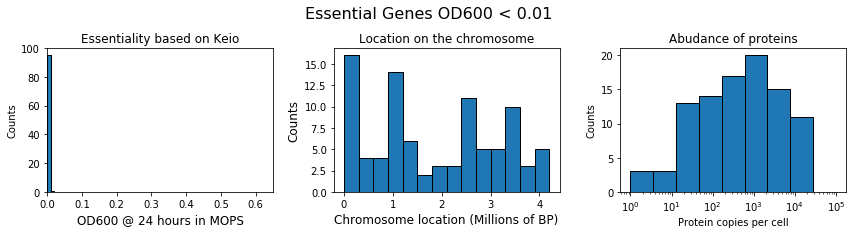

In [6]:
# Pull out genes with no growth in MOPS
df4 = df3.loc[(df3['MOPS_24hr'] <= 0.01)]

Chrom_loc = []
for loc in df4['Location']:
    Chrom_loc.append(int(loc.split('..')[0]))

plt.figure(figsize=(12, 3))

plt.subplot(131)
bins = np.arange(0, 0.6, 0.01)
plt.hist(df4['MOPS_24hr'], edgecolor='k', bins=bins)
plt.xlabel('OD600 @ 24 hours in MOPS', fontsize=12)
plt.ylabel('Counts')
plt.title('Essentiality based on Keio')
plt.xlim(0, 0.65)

plt.subplot(132)
bins = np.arange(0, 4500000, 300000)
plt.hist(Chrom_loc, edgecolor='k', bins=bins)
plt.xticks([0, 1000000, 2000000, 3000000, 4000000], [0, 1, 2, 3, 4])
plt.xlabel('Chromosome location (Millions of BP)', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.title('Location on the chromosome')

plt.subplot(133)
bins = np.logspace(0, 5, 10)
plt.hist(df4['Copy_number'], bins=bins, edgecolor='k')
plt.xscale('log')
plt.title('Abudance of proteins')
plt.xlabel('Protein copies per cell')
plt.ylabel('Counts')

plt.suptitle('Essential Genes OD600 < 0.01', y=1.07, fontsize=16)
plt.tight_layout()
plt.show()

## Selecting genes by COG pathway

To power any statistical comparisons between genes from different COG pathways, we aim to have at least four genes per included COG pathway. Thus, we bin potential genes by pathways and identify which pathways are represented by at least four genes. These pathways are considered in downstream analysis.

In [7]:
# Genes selected from pathways
folate_genes = ['folA', 'thyA', 'folC', 'glyA', 'gcvH', 'metH', 'metF', 'folD', 'purU', 'purN', 'purT', 'purH', 'fmt']

# From Gene Wei-Li lab Cell 2018 for glycolysis selection
# Eliminated a few genes that were non essential from this list and had homologues: 'pfkB', 'fbaB'
# 'ptsG', 'malX', 'crr' excluded because they are redudant and have no effect on growth
gly_genes = ['pgi', 'pfkA', 'fbaA', 'tpiA', 'gapA', 'pgk', 'gpmA', 'eno', 'pykA', 'pykF', 'gpmM']

# Combined list of genes from folate metabolism and glycolysis
path_genes = folate_genes + gly_genes

In [8]:
# Bin the genes by functional process based on cogs
func_dict = {}
count_dict = {}
for gene in df4.index:
    if gene not in path_genes:
        func = df4['COG'].loc[gene][-1]
        if func in func_dict.keys():
            func_dict[func].append(gene)
            count_dict[func] += 1
        else:
            func_dict[func] = []
            func_dict[func].append(gene)
            count_dict[func] = 1

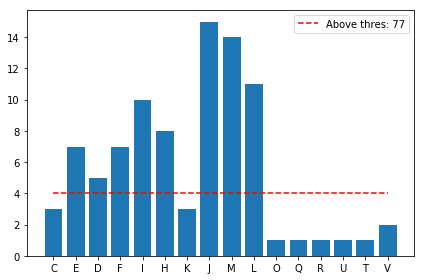

In [9]:
# For statistical power in downstream analysis, we hope to have >= 4 genes in any included pathway
ct = 4 # Minimum number of genes
count = 0 # Number of genes in COG pathways with at least ct genes in our set
for key in count_dict.keys():
    if count_dict[key] > ct:
        count += count_dict[key]
index = np.arange(len(count_dict.keys()))

plt.bar(index, count_dict.values())
plt.xticks(index, count_dict.keys())
plt.plot(index, [ct]*len(index), '--r', label='Above thres: '+ str(count))
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
func_dict

{'C': ['cydA', 'fldA', 'gpsA'],
 'D': ['ftsA', 'ftsK', 'mreB', 'mukB', 'mukF'],
 'E': ['argG', 'aroB', 'aroE', 'dapB', 'proA', 'serC', 'tyrA'],
 'F': ['carA', 'guaA', 'nrdA', 'purA', 'purB', 'purL', 'pyrH'],
 'H': ['birA', 'hemH', 'ispA', 'metK', 'nadE', 'pdxH', 'ribB', 'ribF'],
 'I': ['acpS',
  'fabA',
  'fabD',
  'fabI',
  'fabZ',
  'ispE',
  'ispF',
  'ispG',
  'plsB',
  'pssA'],
 'J': ['aspS',
  'cysS',
  'fusA',
  'glnS',
  'hisS',
  'infA',
  'leuS',
  'metG',
  'prfA',
  'rpsE',
  'serS',
  'tadA',
  'thrS',
  'trpS',
  'valS'],
 'K': ['cysB', 'nusA', 'rpoB'],
 'L': ['dnaA',
  'dnaB',
  'dnaE',
  'dnaX',
  'gyrA',
  'gyrB',
  'holB',
  'ligA',
  'parE',
  'topA',
  'yqgF'],
 'M': ['dapA',
  'glmU',
  'ispH',
  'kdsA',
  'kdsB',
  'lolA',
  'lpxB',
  'lpxD',
  'murA',
  'murB',
  'murE',
  'murF',
  'murG',
  'murI'],
 'O': ['groS'],
 'Q': ['fabB'],
 'R': ['obgE'],
 'T': ['csrA'],
 'U': ['secA'],
 'V': ['lolD', 'msbA']}

## Filtering from 77 to 64
We can titrate 88 genes.  However, 24 of these genes must be from glycolysis and folate metabolism.
So, we need to remove 13 genes from the remaining pathways to match our final total of 88.
From J (translation) there are 10 tRNA synthetases.  We are going to remove 7 of these at random.
From M (cell wall biogensis) we are going to remove 4 random genes.
From L (replication and repair) we are going to remove 1 random gene.
From I (Lipid metabolism) we are going to remove 1 random gene.
Note: As this is done randomly, future executions of this code may not return the genes reported in our paper.

In [10]:
trim_dict = {} # Holds the trimmed essential gene list without glycolysis or folate metabolism genes
tRNA_syn = ['aspS', 'cysS', 'glnS', 'hisS', 'leuS', 'metG', 'serS', 'thrS', 'trpS', 'valS']

for key in func_dict:
    if count_dict[key] >= 4:
        if key == 'J':
            tRNA_rand = random.sample(tRNA_syn, 3)
            trim_dict[key] = []
            for gene in func_dict[key]:
                if gene in tRNA_syn:
                    if gene in tRNA_rand:
                        trim_dict[key].append(gene)
                else:
                    trim_dict[key].append(gene)
        elif key == 'M':
            rand = random.sample(func_dict[key], len(func_dict[key])-4)
            trim_dict[key] = []
            for gene in func_dict[key]:
                if gene in rand:
                    trim_dict[key].append(gene)
        elif key == 'L':
            rand = random.sample(func_dict[key], len(func_dict[key])-1)
            trim_dict[key] = []
            for gene in func_dict[key]:
                if gene in rand:
                    trim_dict[key].append(gene)
        elif key == 'I':
            rand = random.sample(func_dict[key], len(func_dict[key])-1)
            trim_dict[key] = []
            for gene in func_dict[key]:
                if gene in rand:
                    trim_dict[key].append(gene)
        else:
            for gene in func_dict[key]:
                if key in trim_dict.keys():
                    trim_dict[key].append(gene)
                else:
                    trim_dict[key] = []
                    trim_dict[key].append(gene)

# Sanity check
print('There are ' + str(len(np.hstack(trim_dict.values()))) + ' genes in trim_dict.')
Selected_genes = np.hstack(trim_dict.values() + path_genes)
print('There are ' + str(len(np.hstack(Selected_genes))) + ' genes selected for CRISPRi gradients.')
print('The number of unique genes in Selected_genes is ' + str(len(set(Selected_genes))))

There are 64 genes in trim_dict.
There are 88 genes selected for CRISPRi gradients.
The number of unique genes in Selected_genes is 88


In [11]:
# Dataframe with all the information associated with each selected gene
df_select = pd.DataFrame(columns=df_KCYA.columns)
for gene in Selected_genes:
    if gene in df_KCYA.index:
        df_select.loc[gene] = df_KCYA.loc[gene]
    else:
        print gene

## Information about genes selected for gradient CRISPRi

Now that 88 genes have been identified, we plot distributions of chromosomal location, expected growth rate of a complete gene knockdown, and copy number. In our data, copy number and chromosomal location are well-distributed. As expected, the vast majority of genes in our set have no measured growth rate in MOPS following complete knockdown.

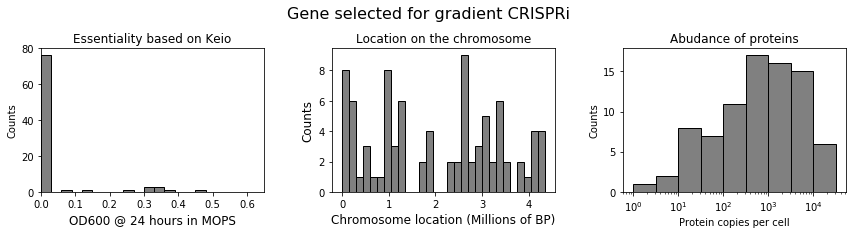

In [12]:
Chrom_loc = []
for loc in df_select['Location']:
    Chrom_loc.append(int(loc.split('..')[0]))

plt.figure(figsize=(12, 3))
plt.subplot(131)
bins = np.arange(0, 0.6, 0.03)
GR = np.array(df_select['MOPS_24hr'])
Mask1 = ~np.isnan(GR)

plt.hist(GR[Mask1], edgecolor='k', bins=bins, color='grey')
plt.xlabel('OD600 @ 24 hours in MOPS', fontsize=12)
plt.ylabel('Counts')
plt.title('Essentiality based on Keio')
plt.xlim(0, 0.65)

plt.subplot(132)
bins = np.arange(0, 4500000, 150000)
plt.hist(Chrom_loc, edgecolor='k', bins=bins, color='grey')
plt.xticks([0, 1000000, 2000000, 3000000, 4000000], [0, 1, 2, 3, 4])
plt.xlabel('Chromosome location (Millions of BP)', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.title('Location on the chromosome')

plt.subplot(133)
bins = np.logspace(0, 4.5, 10)
copy = np.array(df_select['Copy_number'])
Mask2 = ~np.isnan(copy)
plt.hist(copy[Mask2], bins=bins, edgecolor='k', color='grey')
plt.xscale('log')
plt.title('Abudance of proteins')
plt.xlabel('Protein copies per cell')
plt.ylabel('Counts')

plt.suptitle('Gene selected for gradient CRISPRi', y=1.07, fontsize=16)
plt.tight_layout()
plt.show()

## Chromosomal location

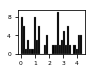

In [13]:
# Figure S2A. Note: Random dropping from gene families will likely result in differences between the published figure
# and the figure output here.
plt.figure(figsize=(1.2, 0.8))
bins = np.arange(0, 4500000, 150000)
plt.hist(Chrom_loc, edgecolor='grey', bins=bins, color='k', lw=0.25)
plt.xticks([0, 1000000, 2000000, 3000000, 4000000], [0, 1, 2, 3, 4], fontsize=6)
plt.yticks([0, 4, 8], fontsize=6)
plt.savefig(figure_path + date + '_location_FigS2A.pdf', transparent=True)
plt.show()

## Copy number

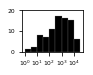

In [14]:
# Figure S2B. Note: Random dropping from gene families will likely result in differences between the published figure
# and the figure output here.
plt.figure(figsize=(1.4, 1.15))
bins = np.logspace(0, 4.5, 10)
copy = np.array(df_select['Copy_number'])
Mask2 = ~np.isnan(copy)
plt.hist(copy[Mask2], bins=bins, edgecolor='grey', color='k', linewidth=0.25)
plt.xscale('log')
plt.xticks([1, 10, 100, 1000, 10000], fontsize=6)
plt.yticks([0, 10, 20], fontsize=6)
plt.tight_layout()
plt.savefig(figure_path + date + '_Abundance_FigS2B.pdf', transparent=True)
plt.show()

## COG Pathway and Essentiality

From our initial list of gene candidates, we selected and subsampled genes from a wide range of cellular processes, the majority of which are expected to be essential.

gpmM


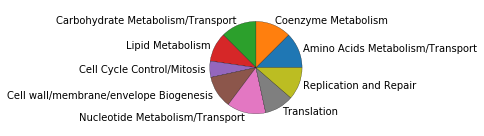

In [15]:
# Figure 1A
# COG Pathway pie chart
plt.figure(figsize=(2, 2))
pie_func = {}
pie_ES = {}
pie_ES['Essential'] = 0
pie_ES['Nonessential'] = 0
for gene in df_select.index:
    func = L2Func[df_select['COG'].loc[gene][-1]]
    if func in pie_func.keys():
        pie_func[func] += 1
    else:
        pie_func[func] = 1
    ES = df_select['MOPS_24hr'].loc[gene]
    if ES <= 0.01:
        pie_ES['Essential'] +=1
    elif ES > 0.01:
        pie_ES['Nonessential'] +=1
    else:
        print gene
        pie_ES['Nonessential'] +=1

plt.pie(pie_func.values(), labels=pie_func.keys(), wedgeprops={'linewidth': 0.25, 'edgecolor' : 'k'}, 
        textprops={'fontsize':'12'})
plt.tight_layout()
plt.savefig(figure_path + date + '_Gene_annotation_Fig1A.pdf', transparent=True)
plt.show()

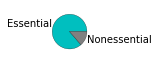

In [16]:
# Essentiality pie chart
plt.figure(figsize=(1, 1))
plt.pie(pie_ES.values(), labels=pie_ES.keys(), colors=['c', 'grey'], 
        wedgeprops={'linewidth': 0.25, 'edgecolor' : 'k'}, textprops={'fontsize':'12'})
plt.tight_layout()
plt.savefig(figure_path + date + '_Essentiality.pdf', transparent=True)
plt.show()